In [128]:
from survival_analysis import prepare_df, obtain_survival_fractions, obtain_total_alive_count
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import quad

In [129]:
df = prepare_df()

In [130]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


[0.12218056 0.05819897 8.97407932 9.99474502]


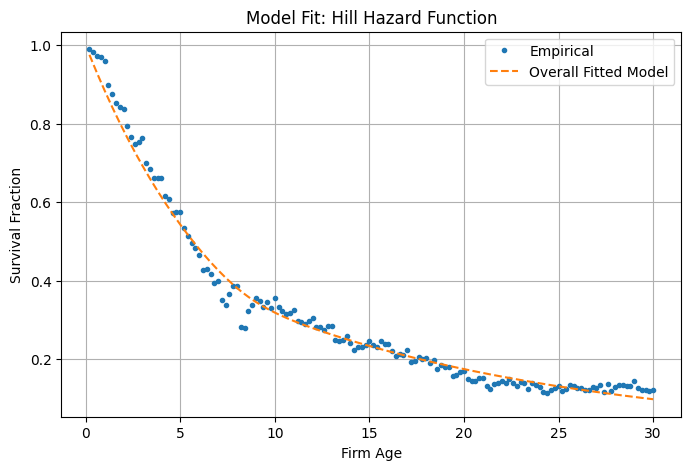

In [131]:
# ---- Step 1: Define the Hill-type hazard function ----

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# ---- Step 4: Objective function to minimize squared error between model and empirical ----

def objective_hill(params, ages, observed_survival):
    mu_ub, mu_lb, K, m = params
    if mu_ub < mu_lb or mu_ub < 0 or mu_lb < 0:
        return np.inf
    predicted = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    return np.sum((predicted - observed_survival)**2)

# ---- Step 5: Fit parameters ----

def fit_survival_model(ages, survival_fractions, initial_guess=[0.1, 0.05, 5, 10]):
    '''
    Returns the params of the Hill function model giving the least squares error

    Inputs:
    ages = firm age bins
    survival_fractions = survival fraction of firms in each age bin
    initial_guess = initial guess for params [mu_ub, mu_lb, K, m]

    ''' 
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 30), (0.5, 100)]
    result = minimize(objective_hill, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# ---- Step 6: Example usage with your data ----

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)


# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()
surv_frac = surv_frac.loc[~(surv_frac == 0).any(axis=1)]
survival_fractions = np.array(surv_frac['status'])
ages = surv_frac['age_bin'].apply(lambda x: x.right)

result = fit_survival_model(ages, survival_fractions, [0.2, 0.05, 5, 10])
best_params = result.x
overall_predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title("Model Fit: Hill Hazard Function")
plt.grid(True)
plt.legend()
plt.show()

[ 0.10698767  0.07005163 12.27842249  5.29302629]


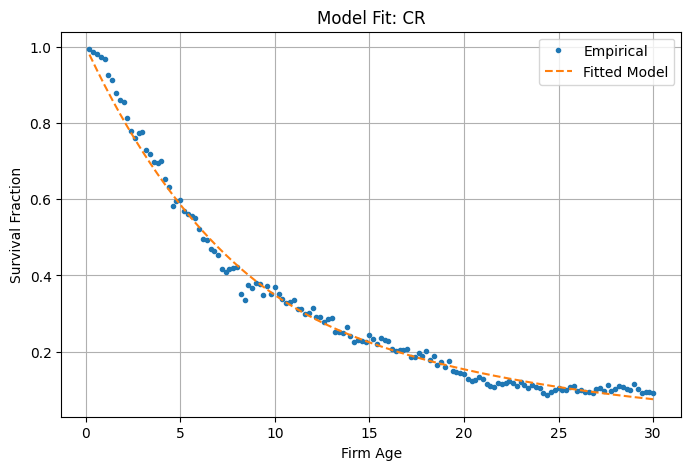

In [132]:
survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', 'CR')

result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 5, 5])
best_params = result.x
predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# Plot model against empirical
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
plt.plot(ages, predicted_curve, '--', label="Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title(f"Model Fit: {'CR'}")
plt.grid(True)
plt.legend()
plt.show()

In [133]:
region_list = ['NR','WR','CR','ER','NER']

for region in region_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', region)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 8, 7])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{region}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit: {region}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

NR: [0.13574074 0.01468059 8.98681485 6.98910326]
WR: [1.38430198e-01 2.40743321e-02 8.60829976e+00 1.00000000e+02]
CR: [ 0.10726301  0.07506883 10.92019325  7.1731328 ]
ER: [0.14417409 0.02666826 9.64267196 7.01975396]
NER: [1.49819923e-01 3.71745141e-02 8.25944516e+00 1.00000000e+02]


F: [7.95451394e-02 1.00000000e-10 2.86208492e+01 1.20016318e+01]


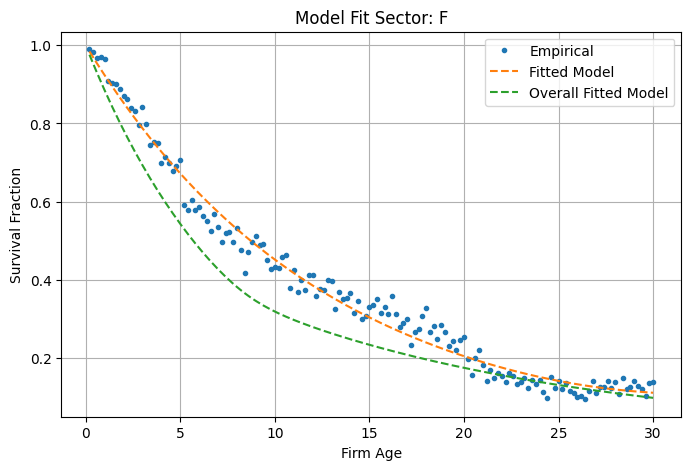

L: [7.57562545e-02 5.85673152e-03 2.61705419e+01 1.00001744e+01]


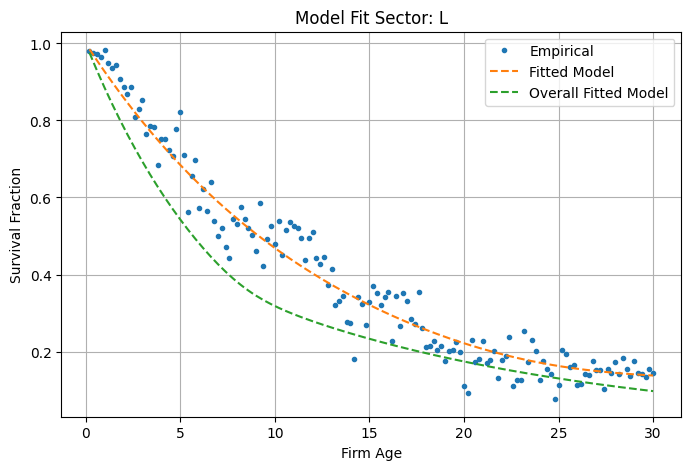

In [134]:
sector_list = ['F', 'L']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.07998763144579782, 0.01, 26.17074846209418, 10.0])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit Sector: {sector}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [135]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.03, 9, 5])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit Sector: {sector}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

G: [ 0.13557522  0.06119486  9.91849406 28.38311413]
M: [ 0.1097038   0.04915758 11.80623629  5.40536658]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



F: [0.1427709  0.02096383 8.82787014 4.98418077]
J: [ 0.13237389  0.05570599  9.59631671 10.65479667]
K: [7.23783075e-02 6.42586191e-03 1.74452406e+01 7.90813087e+00]
C: [1.01329521e-01 4.86098565e-02 8.52078967e+00 1.00000000e+02]
H: [1.56593845e-01 4.61011957e-02 6.90836221e+00 1.00000000e+02]
S: [1.40395123e-01 1.00000000e-10 1.29034243e+01 5.10492401e+00]
N: [1.23256911e-01 1.00000000e-10 1.62314134e+01 3.93352839e+00]
I: [1.27228116e-01 1.00000000e-10 2.07385425e+01 3.73563528e+00]
P: [1.21430437e-01 6.70227866e-02 9.47950096e+00 1.00000000e+02]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



L: [0.14010446 0.02054281 8.80146452 4.98057058]
Q: [7.87171729e-02 4.78400817e-02 7.56228664e+00 1.00000000e+02]
R: [1.33214840e-01 8.40125562e-02 8.82437321e+00 1.00000000e+02]


In [136]:
# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill_model_mle(ages, survivors, totals, initial_guess=[0.3, 0.01, 5.0, 2.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K, m]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.01, 30), (0.5, 100)]
    result = minimize(neg_log_likelihood_hill, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x


In [137]:
region_ll_hill = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)
    
    print(f'{fil} {[float(x) for x in [mu_ub, mu_lb, K, m]]}')    

    # # Plot fit
    # fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    # print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    region_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    # plt.title(f'MLE Hill fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


NR [0.13699712254940938, 0.023557042836639785, 8.3138524590206, 100.0]
WR [0.1390788045198461, 0.025641194916701308, 8.486213375315169, 100.0]
CR [0.10403712899953872, 0.05052803074032524, 17.330125422594165, 5.551276305822039]
ER [0.14743304179654187, 0.03815358410544974, 8.499633372820316, 100.0]
NER [0.15153778689264083, 0.03569498855873022, 8.27567996473235, 100.0]


ll for F: -47800.28245812628
params mu_ub, mu_lb, K, m are [0.08, 0.001, 27.0, 8.0]


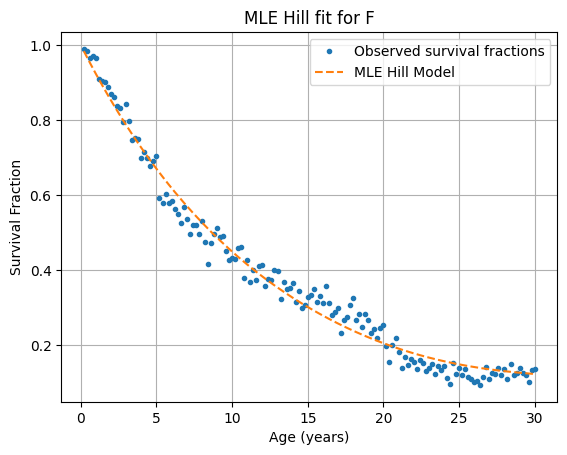

ll for K: -56212.877377536075
params mu_ub, mu_lb, K, m are [0.07011991221882054, 0.011087336854109545, 17.598563453405706, 11.72760709753625]


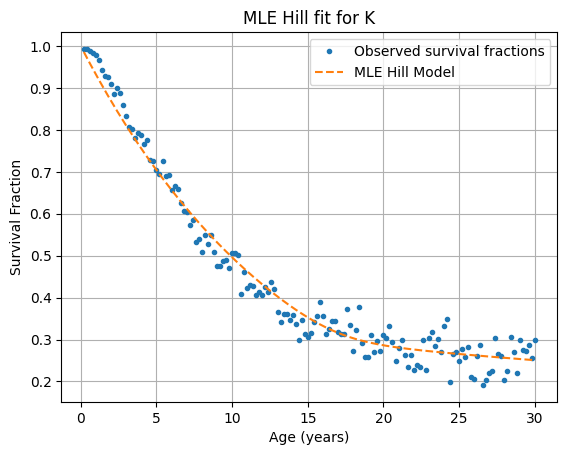

ll for H: -50669.904189963505
params mu_ub, mu_lb, K, m are [0.08, 0.001, 27.0, 8.0]


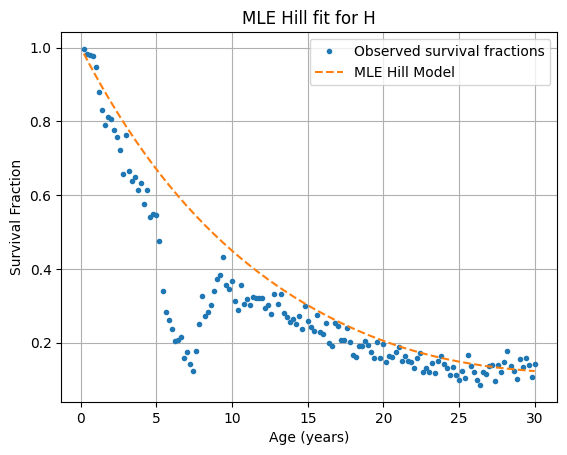

ll for L: -11922.187750263543
params mu_ub, mu_lb, K, m are [0.0742355019671203, 1e-10, 28.27078574805381, 8.561373298763328]


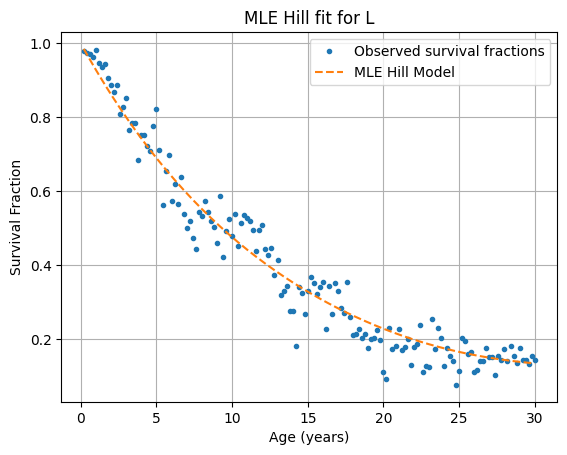

In [138]:
sector_list = ['F', 'K', 'H', 'L']
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, [0.08, 0.001, 27, 8])
    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'params mu_ub, mu_lb, K, m are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

    #-48281.75199323837

G: [ 0.13660052  0.03574548 12.39096153  4.14351094]
ll for G: -198383.82692548522


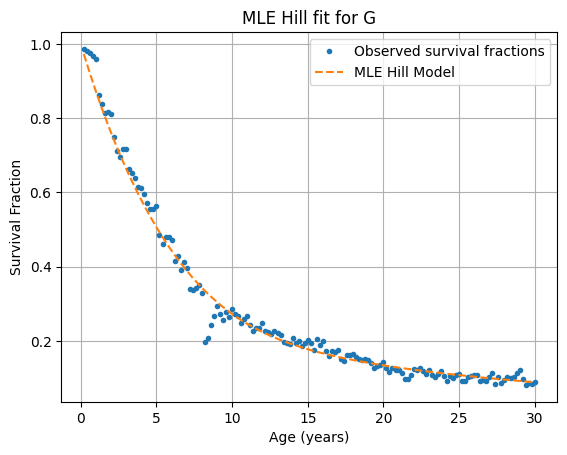

M: [ 0.10853282  0.06037251 10.32973479 19.94287614]
ll for M: -106892.4875486326


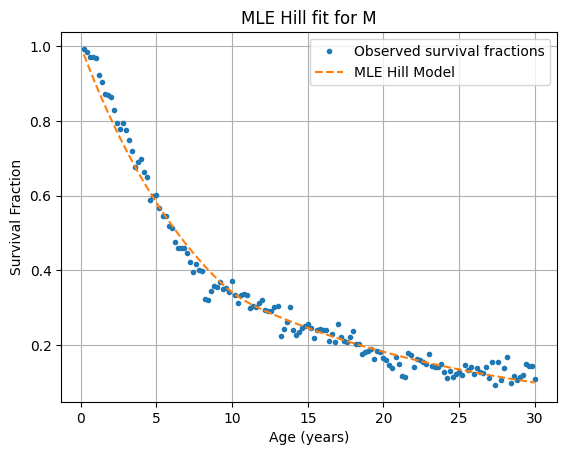

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



F: [ 0.13397868  0.0794196   2.9134405  42.96842779]
ll for F: -48530.51669697335


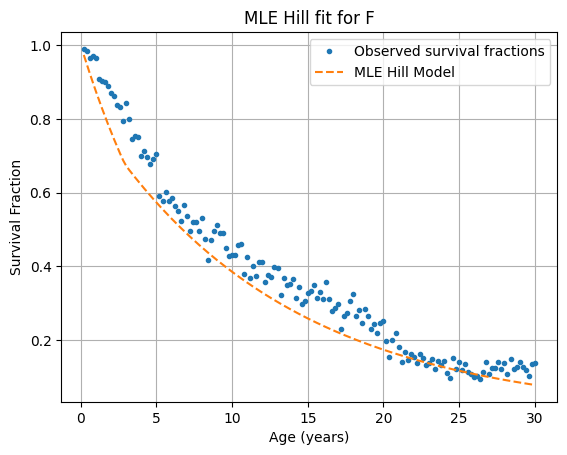

J: [ 0.13090783  0.03791238 11.94294771  4.05656148]
ll for J: -56995.144450477674


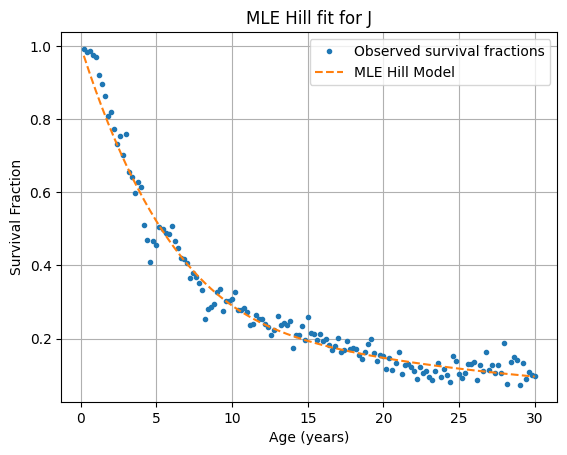

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



K: [7.24639525e-02 6.51738319e-02 1.33583187e+00 7.39694956e+01]
ll for K: -56550.17347105766


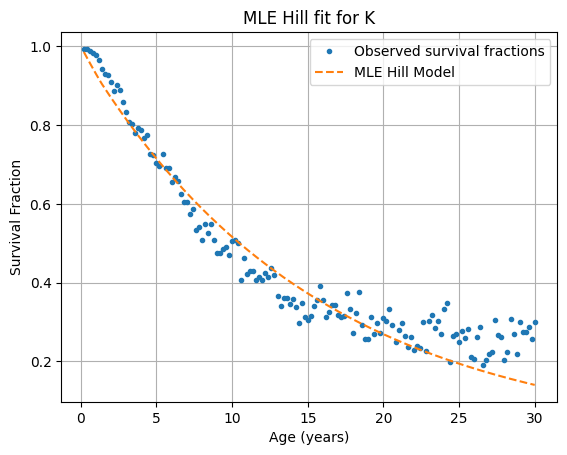

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



C: [0.10300671 0.04137121 9.24989608 8.19115134]
ll for C: -39556.42344403549


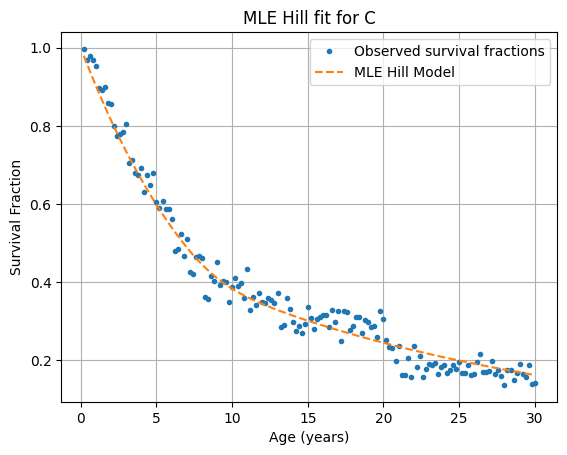

H: [1.90143955e-01 2.80160472e-02 6.93767378e+00 1.00000000e+02]
ll for H: -42974.850496113795


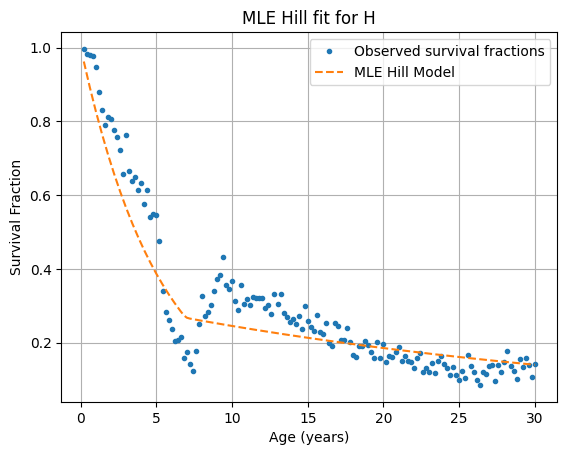

S: [1.40571536e-01 1.00000000e-10 1.29543313e+01 5.19929986e+00]
ll for S: -35752.28673680473


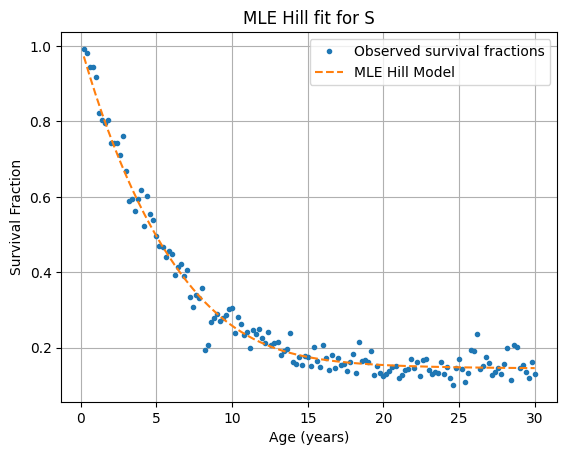

N: [1.23962166e-01 1.00000000e-10 1.64330428e+01 3.67629849e+00]
ll for N: -37012.32213317996


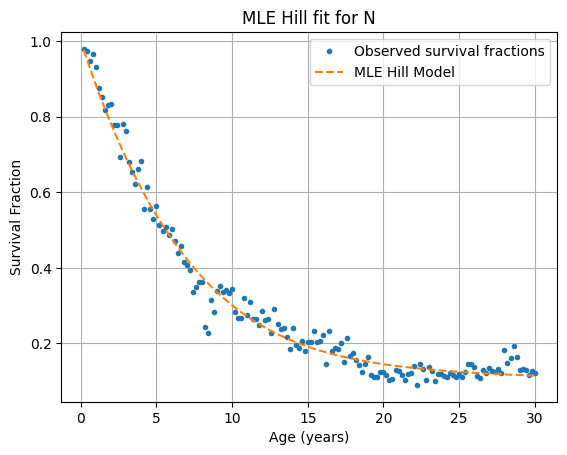

I: [ 0.12568728  0.03446191 17.44362495  5.60658688]
ll for I: -34250.504082915526


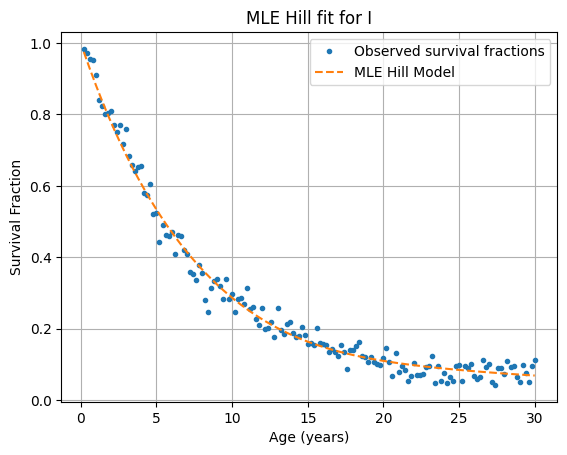

P: [1.21213589e-01 6.86853250e-02 9.44501913e+00 1.00000000e+02]
ll for P: -25155.904575307923


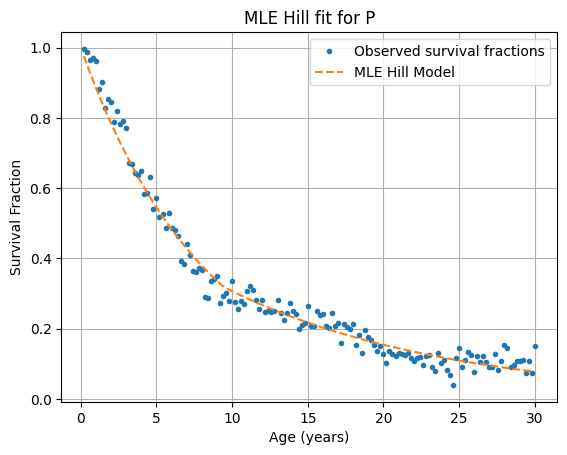

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



L: [ 0.09995808  0.06567182  2.81573854 44.85810659]
ll for L: -11970.809422372087


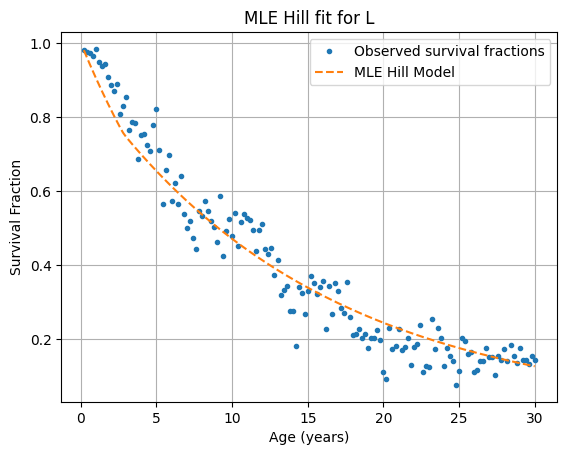

Q: [7.83010438e-02 4.71953411e-02 7.79288658e+00 9.91576599e+01]
ll for Q: -12888.580963190767


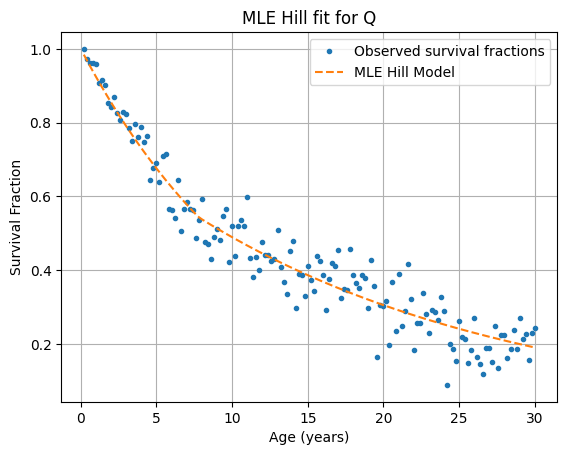

R: [1.32288644e-01 8.54860607e-02 8.85793527e+00 1.00000000e+02]
ll for R: -7519.645951855477


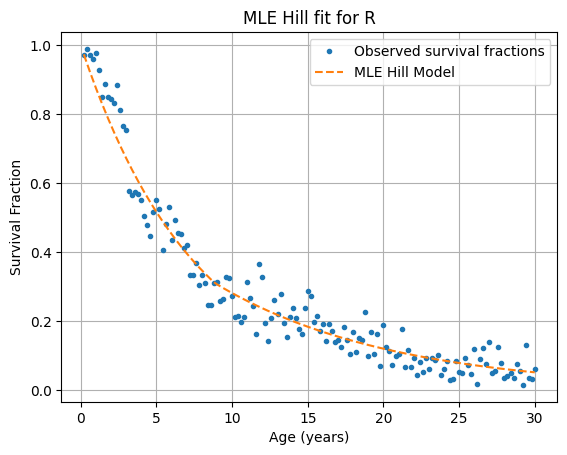

In [139]:
sector_ll_hill = []
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'{fil}: {fit_hill_model_mle(ages, survivors, totals)}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    sector_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

$f(a) = (1+\alpha t) ^{-\lambda / \alpha}$

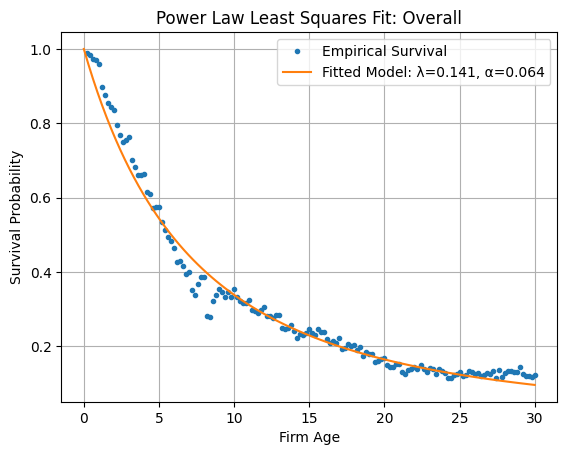

In [140]:
# ---- Closed-form survival function ----
def power_survival_function(t, lam, alpha):
    return (1 + alpha * t) ** (-lam / alpha)

# ---- Predict survival over a list of ages ----
def model_survival_curve_power(ages, lam, alpha):
    return np.array([power_survival_function(t, lam, alpha) for t in ages])

# ---- Least squares objective function ----
def objective_power(params, ages, observed_survival):
    lam, alpha = params
    if lam <= 0 or alpha < 0:
        return np.inf  # invalid parameters
    predicted = model_survival_curve_power(ages, lam, alpha)
    return np.sum((predicted - observed_survival) ** 2)

# ---- Fit the model using least squares ----
def fit_power_model(ages, survival_fractions):
    initial_guess = [0.2, 0.1]  # lambda, alpha
    bounds = [(1e-5, None), (0, None)]
    result = minimize(objective_power, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# - ages: list or array of firm ages
# - survival_fractions: corresponding empirical survival fractions

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)
# Compute survival fraction per bin
survival_fractions, ages = obtain_survival_fractions(df_analysis)

result = fit_power_model(ages, survival_fractions)
lam_fit, alpha_fit = result.x

# Plot result
ages_sorted = np.linspace(0, max(ages), 100)
fitted_survival = model_survival_curve_power(ages_sorted, lam_fit, alpha_fit)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Empirical Survival')
plt.plot(ages_sorted, fitted_survival, label='Fitted Model: λ=%.3f, α=%.3f' % (lam_fit, alpha_fit))
plt.xlabel("Firm Age")
plt.ylabel("Survival Probability")
plt.title("Power Law Least Squares Fit: Overall")
plt.grid(True)
plt.legend()
plt.show()


In [141]:
def neg_log_likelihood_power(params, ages, survivors, totals):
    lam, alpha = params
    if lam <= 0 or alpha <= 0:
        return np.inf

    S = power_survival_function(ages, lam, alpha)
    S = np.clip(S, 1e-12, 1 - 1e-12)  # avoid log(0)
    deaths = totals - survivors

    logL = np.sum(survivors * np.log(S) + deaths * np.log(1 - S))
    return -logL

def fit_power_model_mle(ages, survivors, totals):
    initial_guess = [0.1, 0.1]  # lam, alpha
    bounds = [(1e-6, 1), (1e-6, 1)]
    result = minimize(neg_log_likelihood_power, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x

ll for NR: -59567.647752113546
params lam, alpha are [0.18861949683988236, 0.18894738908806044]


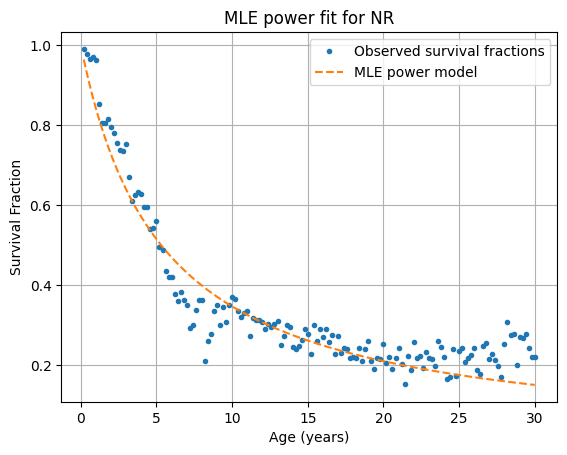

ll for WR: -96324.21879628443
params lam, alpha are [0.1889317727879867, 0.1784994064944407]


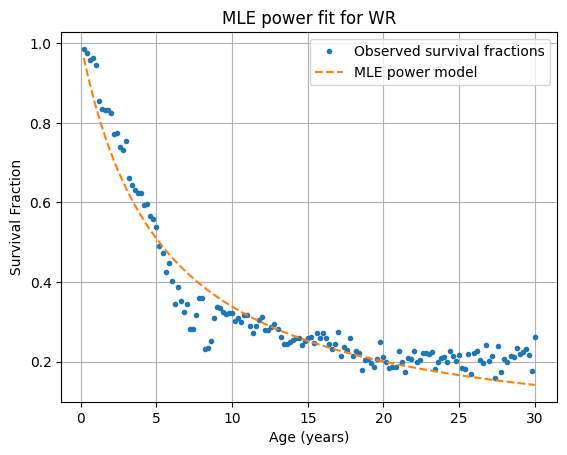

ll for CR: -420253.20088824735
params lam, alpha are [0.11069175198052215, 0.01833526273162147]


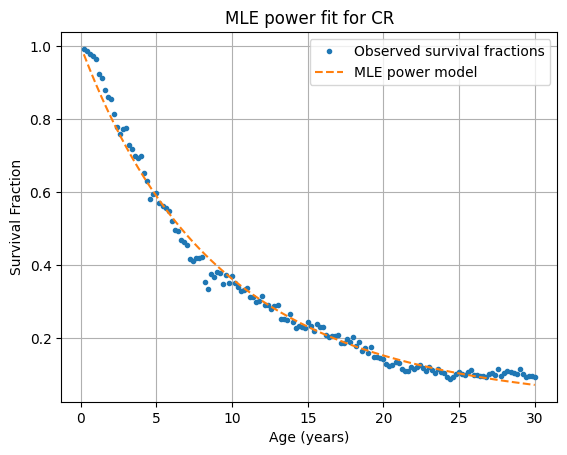

ll for ER: -71816.80620918851
params lam, alpha are [0.1914999850489856, 0.14322746440044906]


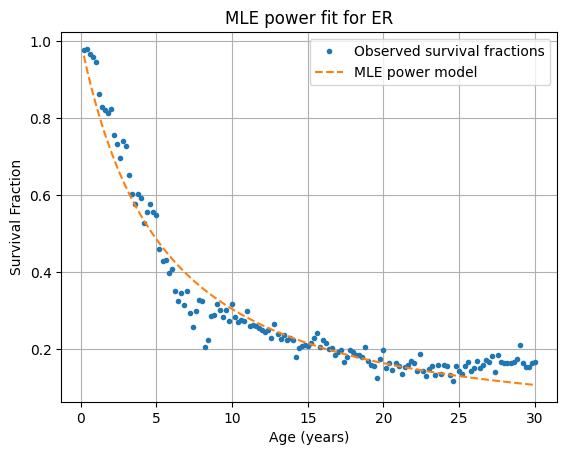

ll for NER: -82060.31237407702
params lam, alpha are [0.1989416080436236, 0.1560263361977802]


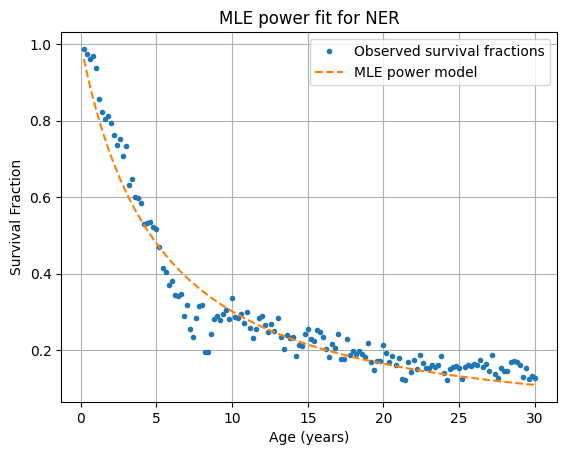

In [142]:
region_ll_power = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    region_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

ll for G: -198944.67602002603
params lam, alpha are [0.15939620783918204, 0.06554741498683739]


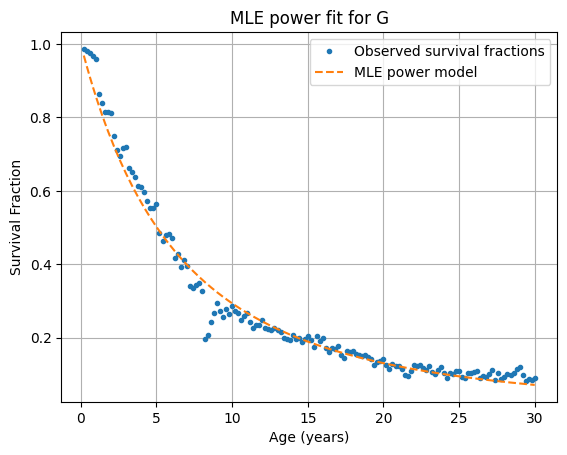

ll for M: -107109.28350819211
params lam, alpha are [0.11731541614021843, 0.034411625163760964]


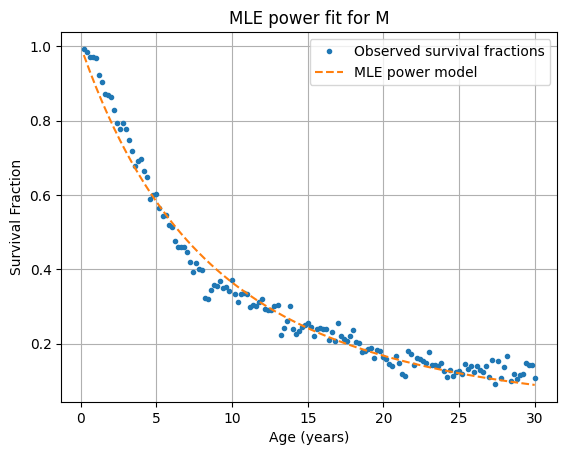

ll for F: -47789.798902493305
params lam, alpha are [0.08176472764699627, 0.003935370422210266]


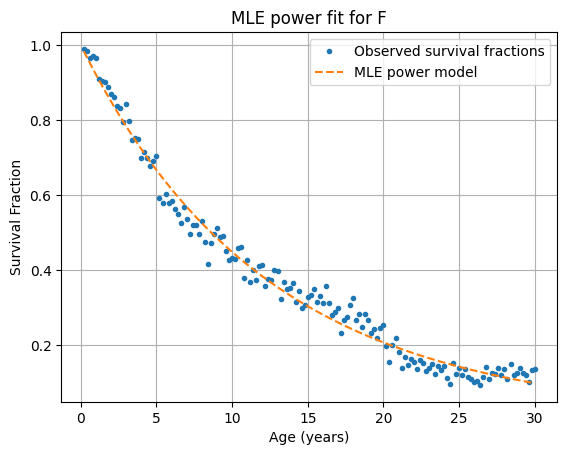

ll for J: -57151.028483457456
params lam, alpha are [0.14493123334359467, 0.05110383747571648]


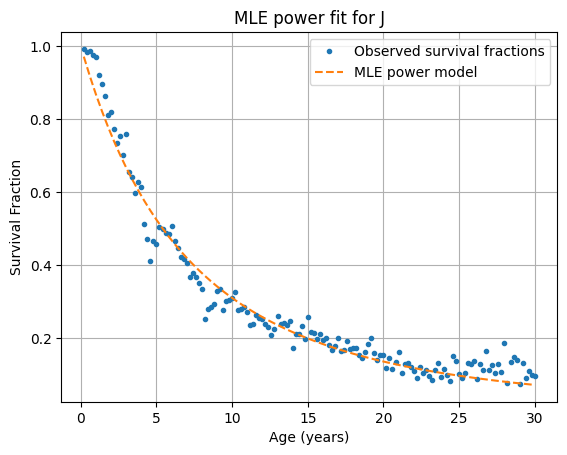

ll for K: -56413.996435860274
params lam, alpha are [0.07428516022902562, 0.0205752635062873]


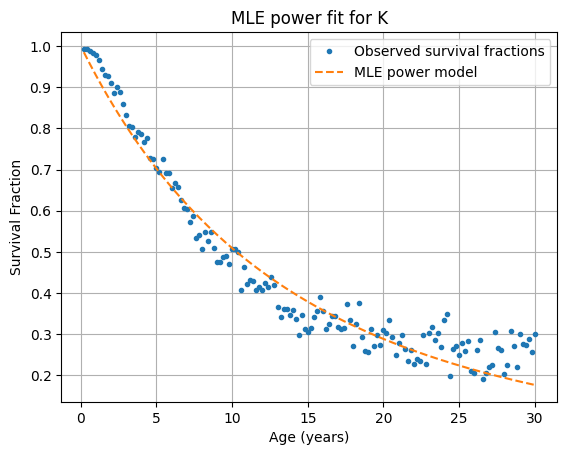

ll for C: -39594.276983044154
params lam, alpha are [0.11483004768371019, 0.06612013174973419]


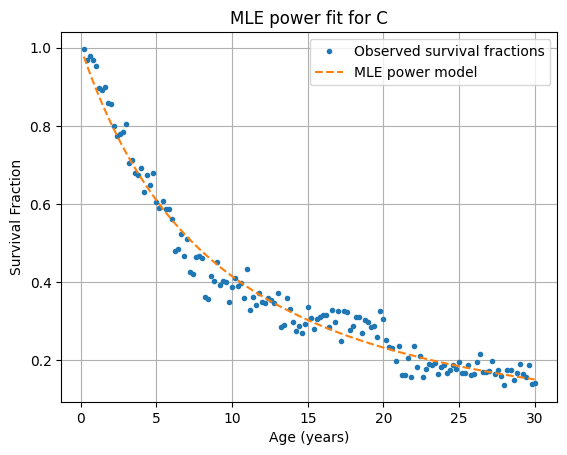

ll for H: -44001.194033550666
params lam, alpha are [0.2887388576800101, 0.29271178534385794]


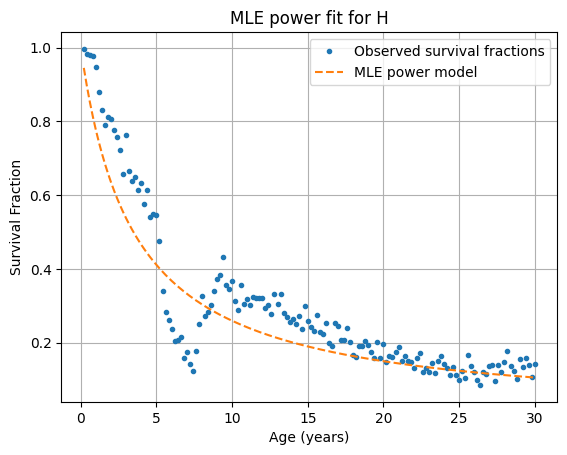

ll for S: -35960.84447700728
params lam, alpha are [0.18288352807518304, 0.11066509005322438]


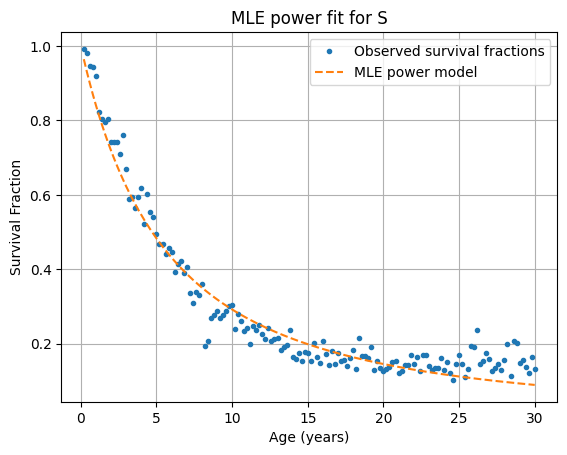

ll for N: -37101.62760374337
params lam, alpha are [0.14828700526875624, 0.06301550110710948]


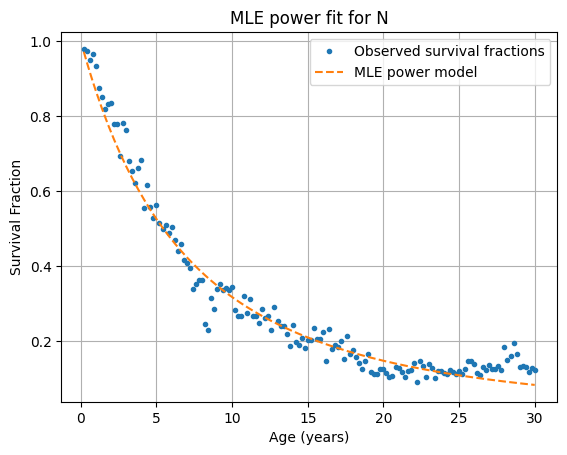

ll for I: -34289.22862246033
params lam, alpha are [0.13748459251913608, 0.02674362264816605]


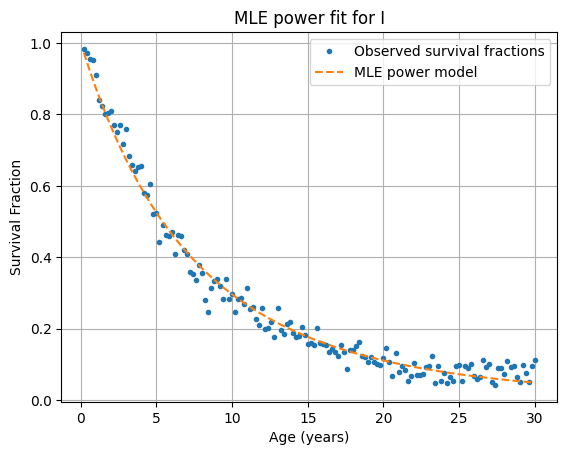

ll for P: -25212.25122378966
params lam, alpha are [0.1318053740138992, 0.03862506384367797]


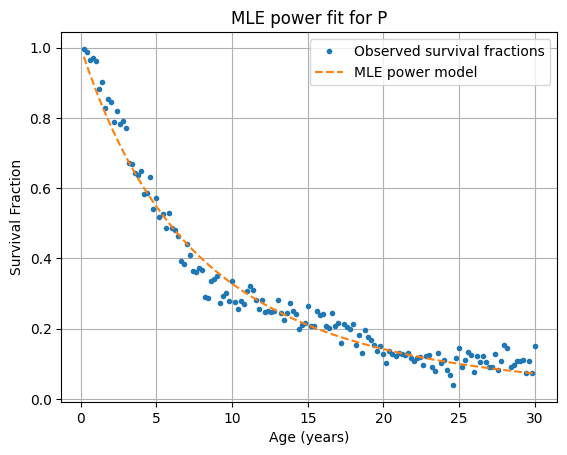

ll for L: -11928.88941323376
params lam, alpha are [0.07361776872843152, 0.0013499979796145912]


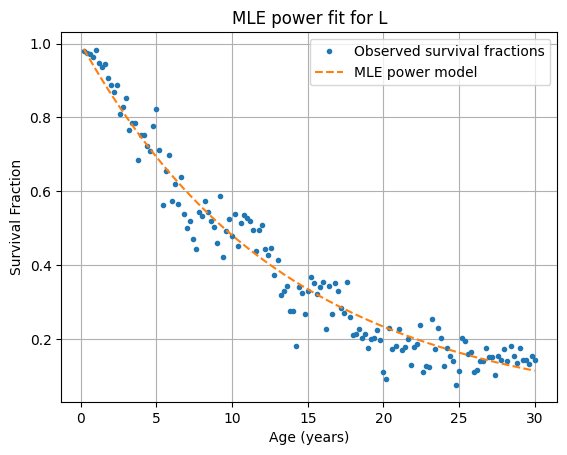

ll for Q: -12903.93185985435
params lam, alpha are [0.08504126133431111, 0.04439811016610487]


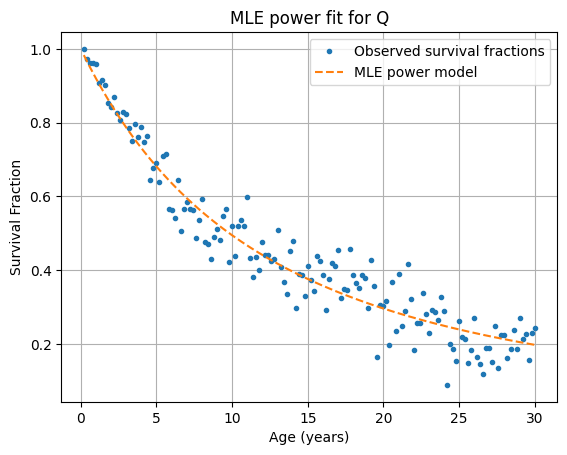

ll for R: -7533.920462008317
params lam, alpha are [0.13942475710811472, 0.029440721713113144]


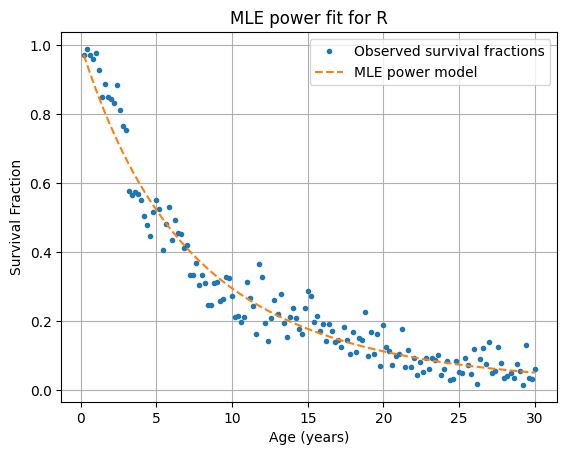

In [143]:
sector_ll_power = []

for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    sector_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [144]:
def compute_aic_bic(neg_logL, k, n):
    '''
    k = number of params
    n = number of observations
    '''

    aic = 2 * k + 2 * neg_logL
    bic = k * np.log(n) + 2 * neg_logL
    return aic, bic

In [145]:
region_aic_hill, region_bic_hill = compute_aic_bic(np.array(region_ll_hill), 4, len(ages))
region_aic_power, region_bic_power = compute_aic_bic(np.array(region_ll_power), 2, len(ages))

In [146]:
sector_aic_hill, sector_bic_hill = compute_aic_bic(np.array(sector_ll_hill), 4, len(ages))
sector_aic_power, sector_bic_power = compute_aic_bic(np.array(sector_ll_power), 2, len(ages))

In [147]:
def constant_survival_function(ages, mu):
    return np.exp(-mu * ages)

def model_survival_curve_constant(ages, mu):
    return np.array([constant_survival_function(_, mu) for _ in ages])

def neg_log_likelihood_constant(mu, ages, survivors, totals):
    if mu < 0:
        return np.inf
    S_vals = model_survival_curve_constant(ages, mu)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12) 
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

def fit_constant_model_mle(ages, survivors, totals, initial_guess=[0.01]):
    bounds = [(1e-6, None)]
    result = minimize(neg_log_likelihood_constant, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result


In [148]:
# Hill function with number of params k=3, where hill coefficient is set constant at m=5

def hill3k_hazard(a, mu_ub, mu_lb, K):
    return mu_ub - (mu_ub - mu_lb) * (a**5) / (a**5 + K**5 + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    return np.array([hill3k_survival_function(a, mu_ub, mu_lb, K) for a in ages])

# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill3k_model_mle(ages, survivors, totals, initial_guess=[0.1, 0.02, 8.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.2), (0.01, 30)]
    result = minimize(neg_log_likelihood_hill3k, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result

In [149]:
region_ll_hill3k = []

for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals)
    print(f'{fil}: {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_hill3k.append(result.fun)

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
sector_ll_hill3k = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals, [7.23785797e-02, 6.43020350e-03, 1.74446268e+01])
    print(f'{fil}: {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    sector_ll_hill3k.append(result.fun)

region_aic_hill3k, region_bic_hill3k = compute_aic_bic(np.array(region_ll_hill3k), 3, len(ages))
sector_aic_hill3k, sector_bic_hill3k = compute_aic_bic(np.array(sector_ll_hill3k), 3, len(ages))

NR: [0.13768678915371127, 0.010770130221976062, 9.069075092998995]
WR: [0.1386662296584102, 0.011459561823651267, 9.452081690940819]
CR: [0.10317770403294278, 1e-10, 23.44391283888089]
ER: [0.14602503768280475, 0.021004219025017697, 9.859731538936233]
NER: [0.15292088568934978, 0.025761587465531855, 8.751184238270035]
G: [0.13694601460801484, 0.044828550983960325, 11.400187222354402]
M: [0.10815485935903067, 0.046534429403804964, 12.551587993746647]
F: [0.07990759050345662, 0.07259775539334294, 19.761032694658233]
J: [0.13114601929546427, 0.04852644454096311, 10.761844890026024]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning:

invalid value encountered in subtract



K: [0.0723785797, 0.0064302035, 17.4446268]
C: [0.10061464949350449, 0.04562232177755028, 9.019425753146153]
H: [0.19652907207241133, 0.023075752349971872, 6.814445087653103]
S: [0.14089893191272135, 1e-10, 12.922741542470776]
N: [0.12139704714112674, 1e-10, 16.58574742182816]
I: [0.12520555667511485, 1e-10, 20.41192969019378]
P: [0.12129591180917582, 0.05989676252678544, 10.670388006038431]
L: [0.07442589296910544, 0.019988812035107793, 30.0]
Q: [0.07931891630319532, 0.04609394229144159, 7.6403433471445386]
R: [0.13249369328223765, 0.08111059169076595, 9.513443945173327]


In [150]:
region_ll_constant = []
for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    print(result.x[0])
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_constant(ages, result.x[0]), label='MLE Constant Model', linestyle='--')
    # plt.title(f'MLE Constant fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_constant.append(result.fun)

sector_ll_constant = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    sector_ll_constant.append(result.fun)

region_aic_constant, region_bic_constant = compute_aic_bic(np.array(region_ll_constant), 1, len(ages))
sector_aic_constant, sector_bic_constant = compute_aic_bic(np.array(sector_ll_constant), 1, len(ages))

0.061223827267648474
0.06628598434456348
0.0675765969312857
0.07453318966595764
0.07266647382982325


In [151]:
region_df_aic = pd.DataFrame({
    'Region': region_list,
    'AIC_Hill': region_aic_hill,
    'AIC_Power': region_aic_power,
    'AIC_Hill3k': region_aic_hill3k,
    'AIC_Constant': region_aic_constant
})
region_df_aic.head()

,Region,AIC_Hill,AIC_Power,AIC_Hill3k,AIC_Constant
0,NR,118068.077117,119139.295504,118195.503403,2.582175e+07
1,WR,190914.527568,192652.437593,191089.909997,4.232045e+07
2,CR,839888.585000,840510.401776,839837.644211,2.080739e+08
3,ER,142705.091828,143637.612418,142760.381960,3.303534e+07
4,NER,162703.662049,164124.624748,162964.703743,3.751901e+07


In [152]:
region_df_bic = pd.DataFrame({
    'Region': region_list,
    'BIC_Hill': region_bic_hill,
    'BIC_Power': region_bic_power,
    'BIC_Hill3k': region_bic_hill3k,
    'BIC_Constant': region_bic_constant
})
region_df_bic.head()

,Region,BIC_Hill,BIC_Power,BIC_Hill3k,BIC_Constant
0,NR,118080.119658,119145.316775,118204.535309,2.582176e+07
1,WR,190926.570110,192658.458863,191098.941903,4.232046e+07
2,CR,839900.627541,840516.423047,839846.676117,2.080739e+08
3,ER,142717.134369,143643.633689,142769.413866,3.303534e+07
4,NER,162715.704591,164130.646019,162973.735649,3.751902e+07


In [153]:
sector_df_aic = pd.DataFrame({
    'Sector': sector_list,
    'AIC_Constant': sector_aic_constant,
    'AIC_Power': sector_aic_power,
    'AIC_Hill3k': sector_aic_hill3k,
    'AIC_Hill': sector_aic_hill,
})
sector_df_aic.head(14)

,Sector,AIC_Constant,AIC_Power,AIC_Hill3k,AIC_Hill
0,G,9.854523e+07,397893.352040,396727.016186,396775.653851
1,M,4.977623e+07,214222.567016,213821.041421,213792.975097
2,F,2.278440e+07,95583.597805,95590.605562,97069.033394
3,J,2.775384e+07,114306.056967,113985.691443,113998.288901
4,K,2.481625e+07,112831.992872,112481.129233,113108.346942
5,C,1.788151e+07,79192.553966,79105.046179,79120.846888
6,H,1.962410e+07,88006.388067,86635.328649,85957.700992
7,S,1.710177e+07,71925.688954,71510.756063,71512.573474
8,N,1.756619e+07,74207.255207,74040.192226,74032.644266
9,I,1.725667e+07,68582.457245,68503.782821,68509.008166


Constant model AIC: 24276350
Other models AIC range: 101961 - 102280
Exclude constant model: True


C:\Users\chong\AppData\Local\Temp\ipykernel_6868\2443602549.py:47: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.



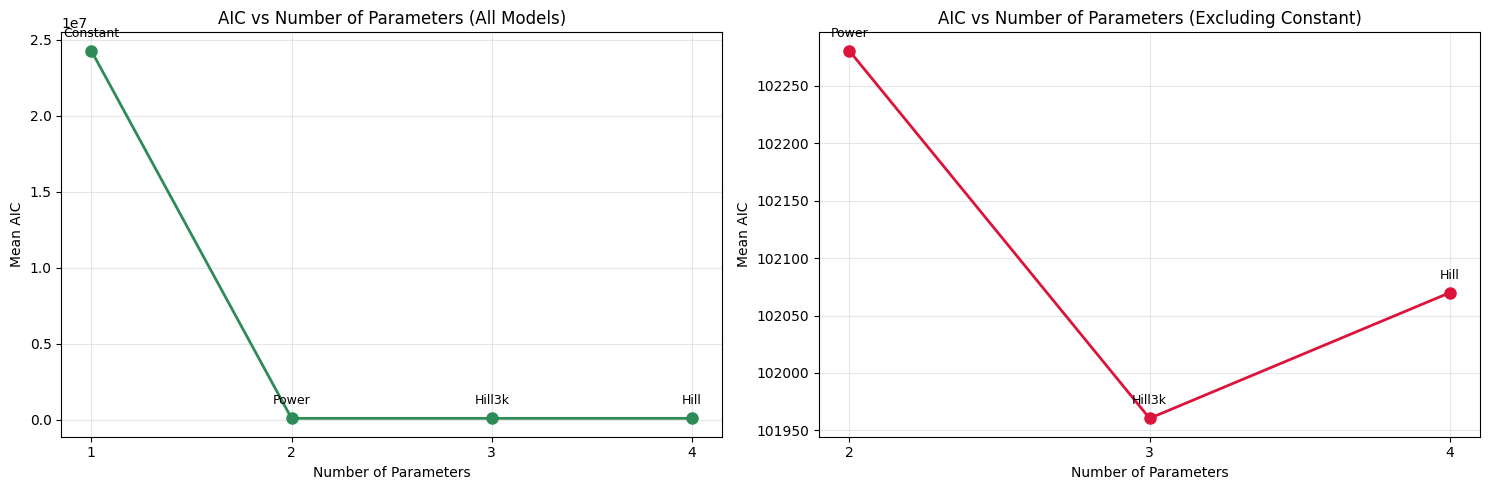

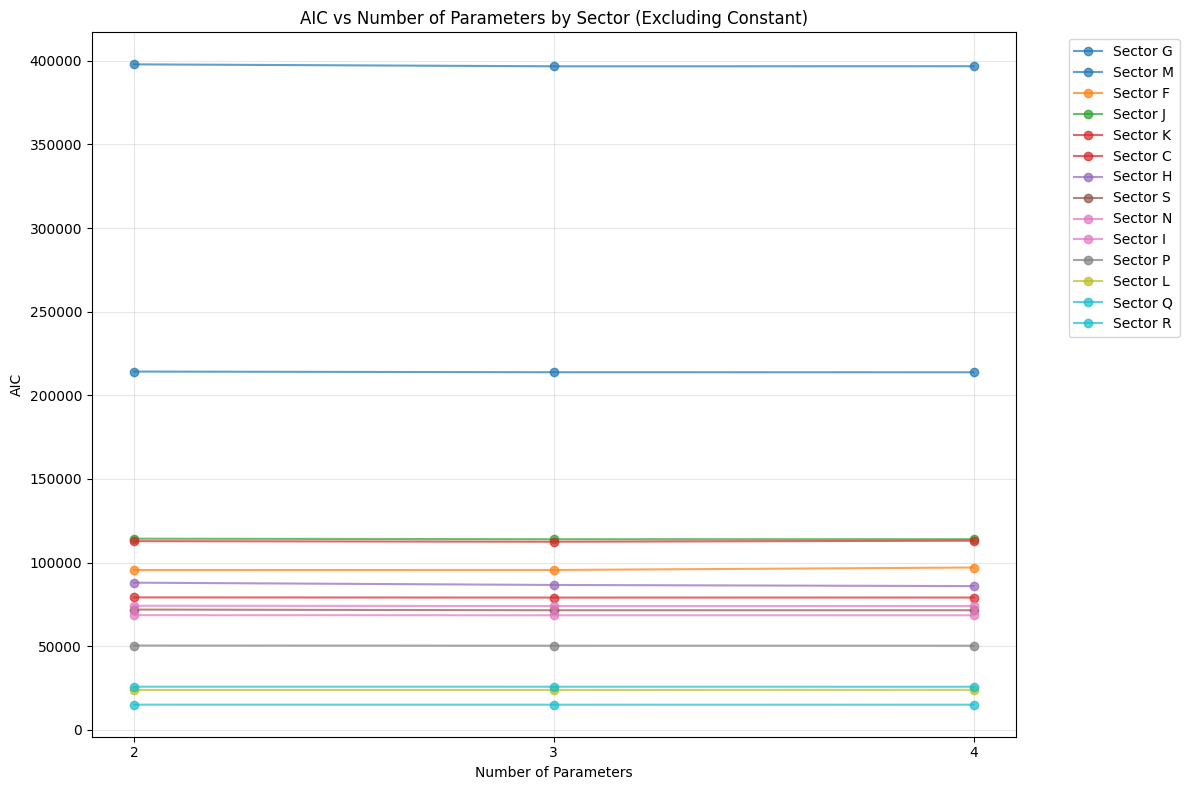

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the number of parameters for each model
model_params = {
    'AIC_Hill': 4,
    'AIC_Power': 2, 
    'AIC_Hill3k': 3,
    'AIC_Constant': 1
}

# Calculate mean AIC values across all sectors for each model
mean_aic = {}
for col in ['AIC_Hill', 'AIC_Power', 'AIC_Hill3k', 'AIC_Constant']:
    mean_aic[col] = sector_df_aic[col].mean()

# Create comparison dataframe
comparison_data = []
for model, aic_val in mean_aic.items():
    comparison_data.append({
        'Model': model,
        'Parameters': model_params[model],
        'Mean_AIC': aic_val
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Parameters')

# Check if Constant model AIC is very different (outlier)
other_models = comparison_df[comparison_df['Model'] != 'AIC_Constant']['Mean_AIC']
constant_aic = comparison_df[comparison_df['Model'] == 'AIC_Constant']['Mean_AIC'].iloc[0]
aic_range = other_models.max() - other_models.min()
constant_diff = abs(constant_aic - other_models.mean())

# Determine if constant should be excluded (if it's more than 2x the range of other models)
exclude_constant = constant_diff > (2 * aic_range)

print(f"Constant model AIC: {constant_aic:.0f}")
print(f"Other models AIC range: {other_models.min():.0f} - {other_models.max():.0f}")
print(f"Exclude constant model: {exclude_constant}")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All models including Constant
axes[0].plot(comparison_df['Parameters'], comparison_df['Mean_AIC'], 'ro-', 
            linewidth=2, markersize=8, color='#2E8B57')
axes[0].set_xlabel('Number of Parameters')
axes[0].set_ylabel('Mean AIC')
axes[0].set_title('AIC vs Number of Parameters (All Models)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([1, 2, 3, 4])

# Add model labels
for _, row in comparison_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    axes[0].annotate(model_name, 
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)

# Plot 2: Exclude Constant if it's an outlier, otherwise show all
if exclude_constant:
    filtered_df = comparison_df[comparison_df['Model'] != 'AIC_Constant']
    title = 'AIC vs Number of Parameters (Excluding Constant)'
    color = '#DC143C'
else:
    filtered_df = comparison_df
    title = 'AIC vs Number of Parameters (All Models)'
    color = '#2E8B57'

axes[1].plot(filtered_df['Parameters'], filtered_df['Mean_AIC'], 'o-', 
            linewidth=2, markersize=8, color=color)
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('Mean AIC')
axes[1].set_title(title)
axes[1].grid(True, alpha=0.3)

if exclude_constant:
    axes[1].set_xticks([2, 3, 4])
else:
    axes[1].set_xticks([1, 2, 3, 4])

# Add model labels for second plot
for _, row in filtered_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    axes[1].annotate(model_name, 
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Alternative: Create individual sector plots to see variation
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each sector as a separate line
colors = plt.cm.tab10(np.linspace(0, 1, len(sector_df_aic)))

for i, (_, sector_row) in enumerate(sector_df_aic.iterrows()):
    sector_name = sector_row['Sector']
    
    # Get AIC values for this sector
    sector_aic = [
        sector_row['AIC_Constant'],  # 1 parameter
        sector_row['AIC_Power'],     # 2 parameters
        sector_row['AIC_Hill3k'],    # 3 parameters
        sector_row['AIC_Hill']       # 4 parameters
    ]
    
    parameters = [1, 2, 3, 4]
    
    # Exclude constant if needed
    if exclude_constant:
        sector_aic = sector_aic[1:]  # Remove first element (Constant)
        parameters = parameters[1:]  # Remove first element (1 parameter)
    
    ax.plot(parameters, sector_aic, 'o-', 
           label=f'Sector {sector_name}', 
           color=colors[i], alpha=0.7, linewidth=1.5)

ax.set_xlabel('Number of Parameters')
ax.set_ylabel('AIC')
if exclude_constant:
    ax.set_title('AIC vs Number of Parameters by Sector (Excluding Constant)')
    ax.set_xticks([2, 3, 4])
else:
    ax.set_title('AIC vs Number of Parameters by Sector')
    ax.set_xticks([1, 2, 3, 4])

ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [155]:
import plotly.express as px
import plotly.graph_objects as go

def create_plotly_for_your_data(df, hide_constant=True):
    """Create simple Plotly plot of AIC vs Model Type"""
    
    # Get AIC columns
    aic_columns = [col for col in df.columns if col.startswith('AIC_')]
    
    # Option to hide AIC_Constant
    if hide_constant and 'AIC_Constant' in aic_columns:
        aic_columns.remove('AIC_Constant')
    
    # Melt the dataframe
    df_melted = df.melt(id_vars=['Sector'], 
                        value_vars=aic_columns,
                        var_name='Model', 
                        value_name='AIC')
    
    # Clean up model names
    df_melted['Model_Name'] = df_melted['Model'].str.replace('AIC_', '')
    
    # Create the plot
    fig = px.line(df_melted, 
                  x='Model_Name', 
                  y='AIC',
                  color='Sector',
                  markers=True,
                  title='AIC Values by Model Type')
    
    # Add mean line
    mean_data = df_melted.groupby('Model_Name')['AIC'].mean().reset_index()
    
    fig.add_trace(go.Scatter(
        x=mean_data['Model_Name'],
        y=mean_data['AIC'],
        mode='lines+markers',
        name='Mean',
        line=dict(color='black', width=3, dash='dash'),
        marker=dict(size=8)
    ))
    
    # Simple layout
    fig.update_layout(
        xaxis_title="Model Type",
        yaxis_title="AIC (lower is better)",
        hovermode='x unified',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ),
        width=1000,
        height=600
    )
    
    return fig

In [156]:
fig = create_plotly_for_your_data(sector_df_aic)
fig.show()

In [157]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'BIC_Hill': sector_bic_hill,
    'BIC_Power': sector_bic_power,
    'BIC_Hill3k': sector_bic_hill3k,
    'BIC_Constant': sector_bic_constant
})
sector_df_bic.head(14)

,Sector,BIC_Hill,BIC_Power,BIC_Hill3k,BIC_Constant
0,G,396787.696392,397899.373311,396736.048092,9.854523e+07
1,M,213805.017638,214228.588287,213830.073326,4.977624e+07
2,F,97081.075935,95589.619076,95599.637468,2.278440e+07
3,J,114010.331442,114312.078238,113994.723349,2.775384e+07
4,K,113120.389483,112838.014142,112490.161139,2.481625e+07
5,C,79132.889429,79198.575237,79114.078085,1.788151e+07
6,H,85969.743533,88012.409338,86644.360555,1.962411e+07
7,S,71524.616015,71931.710225,71519.787969,1.710178e+07
8,N,74044.686808,74213.276478,74049.224131,1.756620e+07
9,I,68521.050707,68588.478516,68512.814727,1.725667e+07


In [158]:
df_long = region_df_aic.melt(id_vars="Region", 
                  var_name="Model", 
                  value_name="AIC_Value")


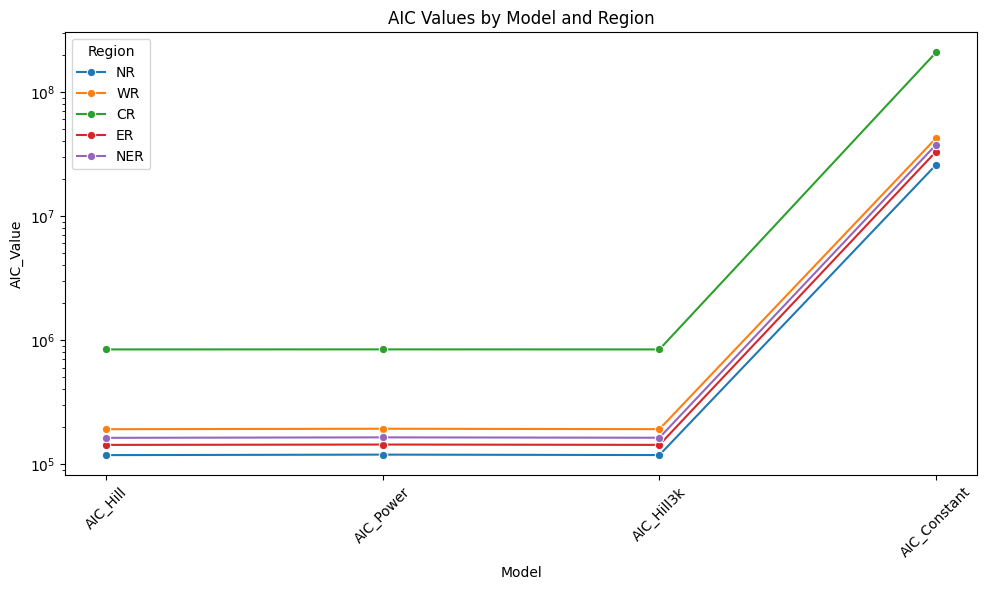

In [159]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x="Model", y="AIC_Value", hue="Region", marker="o")
plt.xticks(rotation=45)
plt.title("AIC Values by Model and Region")
plt.yscale("log")
plt.tight_layout()
plt.show()

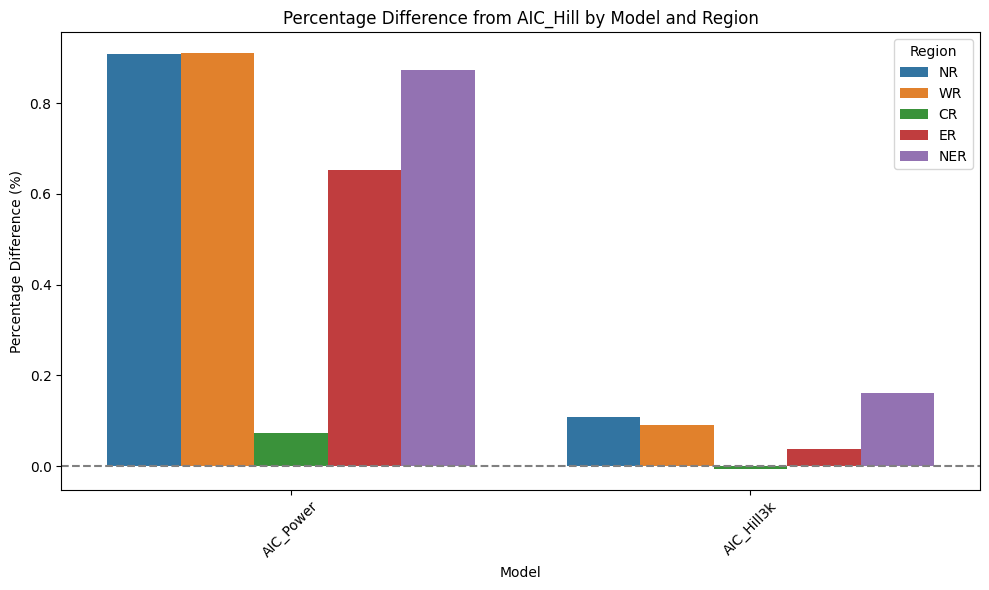

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original AIC values
dftest = region_df_aic.copy()

# Step 1: Calculate % difference from AIC_Hill
base_model = "AIC_Hill"
compare_models = ["AIC_Power", "AIC_Hill3k"]
dftest_diff = dftest[["Region", base_model] + compare_models].copy()

# Compute percentage differences
for model in compare_models:
    dftest_diff[model] = 100 * (dftest_diff[model] - dftest_diff[base_model]) / dftest_diff[base_model]

# Step 2: Reshape for plotting
dftest_melted = dftest_diff.melt(id_vars="Region", 
                         value_vars=compare_models, 
                         var_name="Model", 
                         value_name="Percent_Diff")

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=dftest_melted, x="Model", y="Percent_Diff", hue="Region")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Percentage Difference from AIC_Hill by Model and Region")
plt.ylabel("Percentage Difference (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

params mu_ub, mu_lb, K, m for NR are [0.13699712254940938, 0.023557042836639785, 8.3138524590206, 100.0]
params mu_ub, mu_lb, K, m for WR are [0.1390788045198461, 0.025641194916701308, 8.486213375315169, 100.0]
params mu_ub, mu_lb, K, m for CR are [0.10403712899953872, 0.05052803074032524, 17.330125422594165, 5.551276305822039]
params mu_ub, mu_lb, K, m for ER are [0.14743304179654187, 0.03815358410544974, 8.499633372820316, 100.0]
params mu_ub, mu_lb, K, m for NER are [0.15153778689264083, 0.03569498855873022, 8.27567996473235, 100.0]


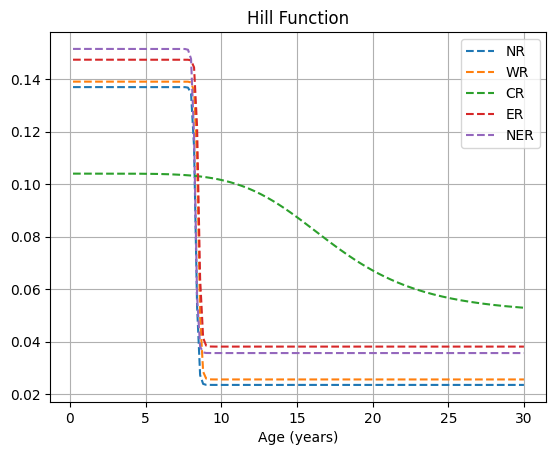

In [161]:
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'params mu_ub, mu_lb, K, m for {fil} are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, hill_hazard(ages, mu_ub, mu_lb, K, m), label = fil, linestyle='--')
plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

In [162]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

df_params.head(14)

,mu_ub,mu_lb,K,m
G,0.136600,3.574423e-02,12.391134,4.143563
M,0.108775,4.180960e-02,12.552693,4.413912
F,0.079990,1.000000e-10,26.182377,79.999864
J,0.130908,3.791174e-02,11.942981,4.056575
K,0.070120,1.107103e-02,17.600632,11.719754
C,0.103010,4.128293e-02,9.260455,8.139253
H,0.190144,2.801602e-02,6.937676,100.000000
S,0.140580,1.000000e-10,12.953553,5.189874
N,0.123962,1.000000e-10,16.432767,3.676400
I,0.125687,3.447114e-02,17.442831,5.606094


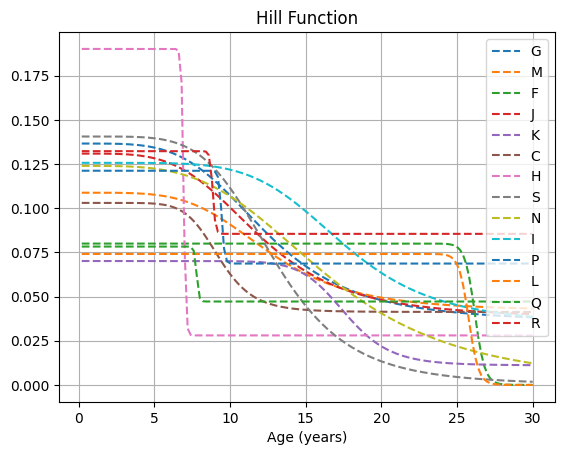

In [163]:
for param in parameters:

    plt.plot(ages, hill_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

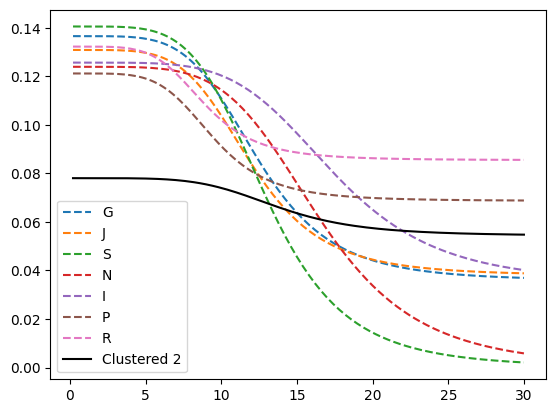

In [165]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

# Plot only for ['G', 'J', 'S', 'N', 'I', 'P', 'R']
selected_sectors = ['G', 'J', 'S', 'N', 'I', 'P', 'R']

# selected2 = ['F', 'K', 'C', 'L', 'Q']

for param in parameters:
    if sector_list[parameters.index(param)] in selected_sectors:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

# # Cluster params
# #   mu_ub: 0.133491
# #   mu_lb: 0.060737
# #   K: 9.922621
# #   m: 30.806709

# plt.plot(ages, hill_hazard(ages, 0.133491, 0.060737, 9.922621, 30.806709), label = 'Clustered', color='black')
# plt.legend()
# plt.show()

# for param in parameters:
#     if sector_list[parameters.index(param)] in selected2:
#         plt.plot(ages, hill_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.074804
#   mu_lb: 0.000000
#   K: 24.163392
#   m: 55.891670

# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.078053
#   mu_lb: 0.054304
#   K: 13.732254
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.078053, 0.054304, 13.732254), label = 'Clustered 2', color='black')
plt.legend()
plt.show()

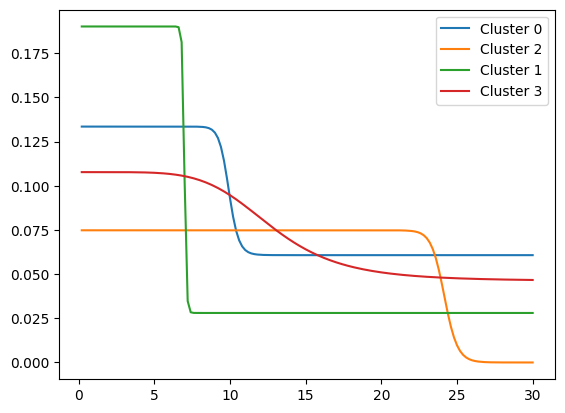

In [166]:
plt.plot(ages, hill_hazard(ages, 0.133491, 0.060737, 9.922621, 30.806709), label = 'Cluster 0')
plt.plot(ages, hill_hazard(ages, 0.074804, 0.000000, 24.163392, 55.891670), label = 'Cluster 2')
# # Cluster 1 (1 sectors): ['H']
#   mu_ub: 0.190143
#   mu_lb: 0.028018
#   K: 6.937616
#   m: 104.814104

# Cluster 3 (1 sectors): ['M']
#   mu_ub: 0.107725
#   mu_lb: 0.046107
#   K: 12.731183
#   m: 5.433634

plt.plot(ages, hill_hazard(ages, 0.190143, 0.028018, 6.987616, 104.814104), label = 'Cluster 1')
plt.plot(ages, hill_hazard(ages, 0.107725, 0.046107, 12.731183, 5.43364), label = 'Cluster 3')

plt.legend()
plt.show()

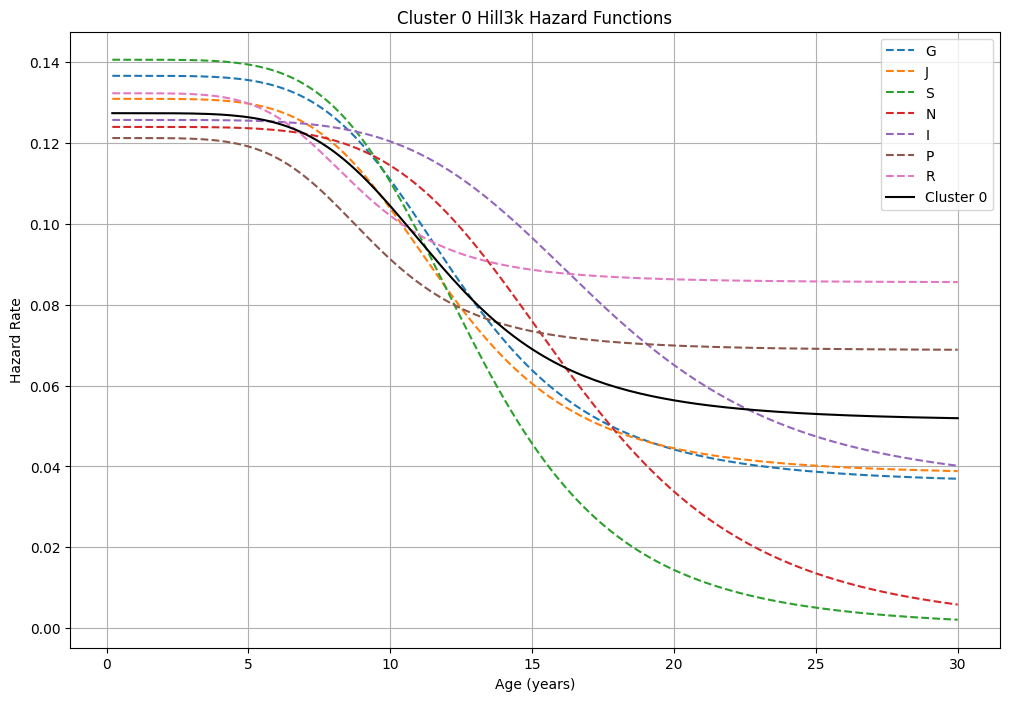

In [167]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

# Plot only for ['G', 'J', 'S', 'N', 'I', 'P', 'R']
cluster_0 = ['J', 'N', 'I', 'P', 'R']

fig, ax = plt.subplots(figsize=(12, 8))

for param in parameters:
    if sector_list[parameters.index(param)] in selected_sectors:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

# Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
#   mu_ub: 0.127360
#   mu_lb: 0.051201
#   K: 11.826997
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.127360, 0.051201, 11.826997), label = 'Cluster 0', color='black')

# Cluster 1 (1 sectors): ['M']
#   mu_ub: 0.108155
#   mu_lb: 0.046538
#   K: 12.551068
#   m: 5.0 (fixed)

# plt.plot(ages, hill3k_hazard(ages, 0.108155, 0.046538, 12.551068), label = 'Cluster 1', color='blue')

# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.078053
#   mu_lb: 0.054305
#   K: 13.731646
#   m: 5.0 (fixed)

# plt.plot(ages, hill3k_hazard(ages, 0.078053, 0.054305, 13.731646), label = 'Cluster 2', color='green')

# Cluster 3 (3 sectors): ['G', 'H', 'S']
#   mu_ub: 0.148172
#   mu_lb: 0.044724
#   K: 9.492480
#   m: 5.0 (fixed)

# plt.plot(ages, hill3k_hazard(ages, 0.148172, 0.044724, 9.492480), label = 'Cluster 3', color='red')

plt.title('Cluster 0 Hill3k Hazard Functions')
plt.xlabel('Age (years)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.grid(True)
plt.show()

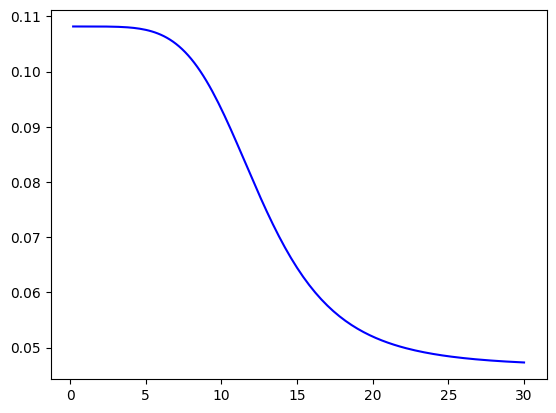

In [168]:
# Cluster 1 (1 sectors): ['M']
#   mu_ub: 0.108155
#   mu_lb: 0.046538
#   K: 12.551068
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.108155, 0.046538, 12.551068), label = 'Cluster 1', color='blue')

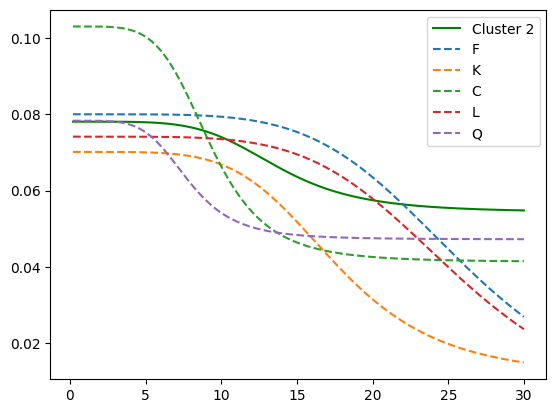

In [189]:
# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.078053
#   mu_lb: 0.054305
#   K: 13.731646
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.078053, 0.054305, 13.731646), label = 'Cluster 2', color='green')

cluster_2 = ['F', 'K', 'C', 'L', 'Q']
for param in parameters:
    if sector_list[parameters.index(param)] in cluster_2:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.legend()
plt.show()

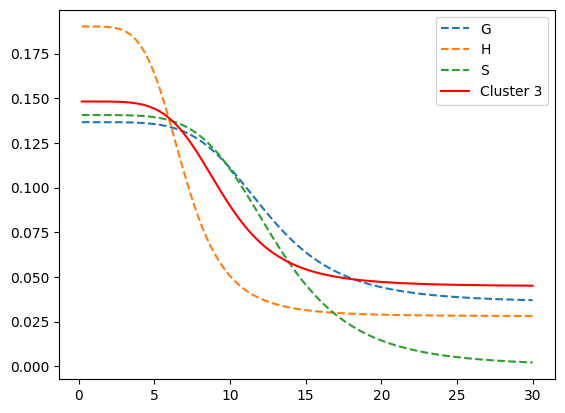

In [170]:
cluster_3 = ['G', 'H', 'S']
for param in parameters:
    if sector_list[parameters.index(param)] in cluster_3:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.plot(ages, hill3k_hazard(ages, 0.148172, 0.044724, 9.492480), label = 'Cluster 3', color='red')

plt.legend()

In [174]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

def hill_exponential_trigger_hazard(a, mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay):
    """
    Hill hazard with exponential decay trigger
    
    Parameters:
    - mu_ub, mu_lb, K: Original Hill parameters
    - trigger_age: Age when trigger event starts
    - trigger_intensity: Peak additional mortality rate
    - trigger_decay: How fast the trigger effect decays (higher = faster decay)
    """
    # Base Hill hazard
    base_hazard = hill3k_hazard(a, mu_ub, mu_lb, K)
    
    # Exponential trigger (only active after trigger_age)
    if a >= trigger_age:
        trigger_hazard = trigger_intensity * np.exp(-trigger_decay * (a - trigger_age))
    else:
        trigger_hazard = 0
    
    total_hazard = base_hazard + trigger_hazard
    return max(0, min(total_hazard, 10.0))  # Bound to prevent numerical issues

def hill_exponential_trigger_survival(a, mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay):
    """
    Survival function for Hill model with exponential trigger
    """
    if a <= 0:
        return 1.0
    
    try:
        # Integrate the hazard function
        result, error = quad(
            lambda s: hill_exponential_trigger_hazard(s, mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay),
            0, a, limit=100, epsabs=1e-8, epsrel=1e-6
        )
        
        result = min(result, 50.0)  # Prevent overflow
        return max(1e-12, min(1.0, np.exp(-result)))
        
    except Exception as e:
        print(f"Integration failed for a={a}: {e}")
        return max(1e-12, np.exp(-a * mu_ub))  # Fallback

def model_survival_curve_exponential_trigger(ages, mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay):
    """
    Vectorized survival curve with exponential trigger
    """
    return np.array([
        hill_exponential_trigger_survival(a, mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay) 
        for a in ages
    ])

def log_likelihood_exponential_trigger(params, ages, survivors, totals):
    """
    Log-likelihood for Hill model with exponential trigger
    
    params = [mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay]
    """
    mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay = params
    
    # Parameter bounds checking
    if (mu_lb < 0 or mu_ub < mu_lb or K <= 0 or 
        trigger_age < 0 or trigger_intensity < 0 or trigger_decay <= 0):
        return -np.inf
    
    # Compute survival probabilities
    S_vals = model_survival_curve_exponential_trigger(ages, mu_ub, mu_lb, K, 
                                                     trigger_age, trigger_intensity, trigger_decay)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)
    
    # Log-likelihood
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def fit_exponential_trigger_model(ages, survivors, totals, initial_hill_params=None):
    """
    Fit Hill model with exponential trigger
    
    Returns: best_params = [mu_ub, mu_lb, K, trigger_age, trigger_intensity, trigger_decay]
    """
    
    # If no initial Hill params provided, use reasonable defaults
    if initial_hill_params is None:
        initial_hill_params = [0.15, 0.01, 10.0]  # Typical values
    
    # Find a good guess for trigger_age by looking at data
    # (largest drop in survival rate)
    survival_fractions = survivors / np.maximum(totals, 1)  # Avoid division by zero
    if len(survival_fractions) > 2:
        # Find biggest drop
        drops = np.diff(survival_fractions)  # Negative values = drops
        biggest_drop_idx = np.argmin(drops)  # Most negative = biggest drop
        trigger_age_guess = ages[biggest_drop_idx + 1]  # Age after the drop
    else:
        trigger_age_guess = np.mean(ages)
    
    # Initial parameter guess
    initial_params = list(initial_hill_params) + [trigger_age_guess, 0.1, 0.5]
    
    # Parameter bounds
    bounds = [
        (1e-6, 1.0),           # mu_ub
        (1e-10, 1.0),          # mu_lb  
        (0.1, 100.0),          # K
        (0.1, max(ages)),      # trigger_age
        (0.001, 2.0),          # trigger_intensity
        (0.01, 5.0)            # trigger_decay
    ]
    
    def neg_log_likelihood(params):
        return -log_likelihood_exponential_trigger(params, ages, survivors, totals)
    
    # Single optimization run
    print(f"  Starting optimization with trigger_age={initial_params[3]:.2f}, "
          f"intensity={initial_params[4]:.3f}, decay={initial_params[5]:.3f}")
    
    try:
        result = minimize(neg_log_likelihood, initial_params, 
                        method='L-BFGS-B', bounds=bounds,
                        options={'maxiter': 200})
        
        if result.success:
            best_ll = log_likelihood_exponential_trigger(result.x, ages, survivors, totals)
            best_params = result.x
            print(f"  Success! LL = {best_ll:.2f}")
        else:
            print(f"  Optimization failed: {result.message}")
            print(f"  Using initial parameters as fallback")
            best_ll = log_likelihood_exponential_trigger(initial_params, ages, survivors, totals)
            best_params = initial_params
            
    except Exception as e:
        print(f"  Error during optimization: {e}")
        print(f"  Using initial parameters as fallback")
        best_ll = log_likelihood_exponential_trigger(initial_params, ages, survivors, totals)
        best_params = initial_params
    
    return best_params, best_ll

def compare_hill_vs_trigger(sector, ages_data, df_analysis, df_params):
    """
    Compare original Hill model vs Hill + exponential trigger for a specific sector
    """
    print(f"\nComparing models for Sector {sector}")
    print("=" * 50)
    
    # Get data
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    valid_mask = totals > 0
    survivors = survivors[valid_mask] 
    totals = totals[valid_mask]
    ages = ages_data[:len(survivors)]
    
    # Original Hill model
    original_params = df_params.loc[sector].values
    original_ll = -neg_log_likelihood_hill3k(original_params, ages, survivors, totals)
    
    print(f"Original Hill Model (3 parameters):")
    print(f"  mu_ub={original_params[0]:.4f}, mu_lb={original_params[1]:.4f}, K={original_params[2]:.4f}")
    print(f"  Log-likelihood: {original_ll:.2f}")
    
    # Hill + exponential trigger model
    print(f"\nFitting Hill + Exponential Trigger Model (6 parameters):")
    trigger_params, trigger_ll = fit_exponential_trigger_model(ages, survivors, totals, original_params)
    
    print(f"\nTrigger Model Results:")
    print(f"  Hill params: mu_ub={trigger_params[0]:.4f}, mu_lb={trigger_params[1]:.4f}, K={trigger_params[2]:.4f}")
    print(f"  Trigger params: age={trigger_params[3]:.2f}, intensity={trigger_params[4]:.4f}, decay={trigger_params[5]:.4f}")
    print(f"  Log-likelihood: {trigger_ll:.2f}")
    
    # Model comparison
    n_obs = len(ages)
    
    # AIC and BIC
    aic_original = -2 * original_ll + 2 * 3
    bic_original = -2 * original_ll + np.log(n_obs) * 3
    
    aic_trigger = -2 * trigger_ll + 2 * 6  
    bic_trigger = -2 * trigger_ll + np.log(n_obs) * 6
    
    print(f"\nModel Comparison:")
    print(f"                    AIC      BIC      ΔLL")
    print(f"Hill (original):   {aic_original:.1f}    {bic_original:.1f}     -")
    print(f"Hill + Trigger:    {aic_trigger:.1f}    {bic_trigger:.1f}    {trigger_ll - original_ll:.1f}")
    
    # Likelihood ratio test
    lr_stat = 2 * (trigger_ll - original_ll)
    from scipy import stats
    p_value = 1 - stats.chi2.cdf(lr_stat, 3)  # 3 additional parameters
    
    print(f"\nLikelihood Ratio Test:")
    print(f"  H0: Original Hill model is adequate")
    print(f"  H1: Trigger model is significantly better") 
    print(f"  LR statistic: {lr_stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'Trigger model significantly better' if p_value < 0.05 else 'No significant improvement'}")
    
    return {
        'original_params': original_params,
        'trigger_params': trigger_params, 
        'original_ll': original_ll,
        'trigger_ll': trigger_ll,
        'aic_original': aic_original,
        'aic_trigger': aic_trigger,
        'lr_test': {'statistic': lr_stat, 'p_value': p_value}
    }

# Example usage for sector H
results_H = compare_hill_vs_trigger('H', ages, df_analysis, df_params)

print(results_H)


Comparing models for Sector H
Original Hill Model (3 parameters):
  mu_ub=0.1901, mu_lb=0.0280, K=6.9377
  Log-likelihood: -43328.71

Fitting Hill + Exponential Trigger Model (6 parameters):
  Starting optimization with trigger_age=5.40, intensity=0.100, decay=0.500
  Success! LL = -42384.40

Trigger Model Results:
  Hill params: mu_ub=0.1190, mu_lb=0.0200, K=4.8465
  Trigger params: age=4.80, intensity=2.0000, decay=2.5633
  Log-likelihood: -42384.40

Model Comparison:
                    AIC      BIC      ΔLL
Hill (original):   86663.4    86672.5     -
Hill + Trigger:    84780.8    84798.9    944.3

Likelihood Ratio Test:
  H0: Original Hill model is adequate
  H1: Trigger model is significantly better
  LR statistic: 1888.63
  p-value: 0.0000
  Result: Trigger model significantly better
{'original_params': array([0.19014391, 0.02801602, 6.93767599]), 'trigger_params': array([0.11896966, 0.02004866, 4.84647718, 4.8023139 , 2.        ,
       2.56332537]), 'original_ll': np.float64(-

In [190]:
def plot_sector_with_trigger(results, sector, ages_data, df_analysis, save_plot=False):
    """
    Plot observed data vs original Hill model vs Hill + exponential trigger model
    """
    # # Get comparison results
    # results = compare_hill_vs_trigger(sector, ages_data, df_analysis, df_params)
    
    # Get data for plotting
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages = ages_data[:len(survivors)]
    
    # Observed survival fractions
    observed_fractions = survivors / totals
    
    # Create smooth age range for model curves
    smooth_ages = np.linspace(min(ages), max(ages), 200)
    
    # Original Hill model predictions
    original_params = results['original_params']
    hill_predictions = model_survival_curve_hill3k(smooth_ages, *original_params)
    
    # Trigger model predictions
    trigger_params = results['trigger_params']
    trigger_predictions = model_survival_curve_exponential_trigger(smooth_ages, *trigger_params)
    
    # Create the plot
    plt.figure(figsize=(10, 7))
    
    # Plot observed data
    plt.scatter(ages, observed_fractions, 
               color='blue', s=10, alpha=0.7, 
               label='Observed survival fractions', zorder=3)
    
    # Plot original Hill model
    plt.plot(smooth_ages, hill_predictions, 
            '--', color='orange', linewidth=2,
            label=f'Original Hill Model (AIC={results["aic_original"]:.1f})')
    
    # Plot trigger model
    plt.plot(smooth_ages, trigger_predictions,
            '-', color='red', linewidth=2.5,
            label=f'Hill + Exponential Trigger (AIC={results["aic_trigger"]:.1f})')
    
    # Add vertical line at trigger age
    trigger_age = trigger_params[3]
    plt.axvline(x=trigger_age, color='red', linestyle=':', alpha=0.7,
               label=f'Trigger age = {trigger_age:.1f} years')
    
    # Formatting
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Survival Fraction', fontsize=12)
    plt.title(f'MLE Hill fit with Exponential Trigger for Sector {sector}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Add parameter annotations
    textstr = f'''Trigger Parameters:
Age: {trigger_params[3]:.2f} years
Intensity: {trigger_params[4]:.3f}
Decay: {trigger_params[5]:.3f}

LR Test p-value: {results["lr_test"]["p_value"]:.4f}'''
    
    plt.text(0.65, 0.95, textstr, transform=plt.gca().transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'sector_{sector}_trigger_model.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as 'sector_{sector}_trigger_model.png'")
    
    plt.show()
    
    # Print summary
    print(f"\nSUMMARY FOR SECTOR {sector}:")
    print(f"Trigger occurs at age {trigger_params[3]:.2f} years")
    print(f"Peak additional mortality: {trigger_params[4]:.3f}")
    print(f"Decay rate: {trigger_params[5]:.3f} (half-life = {np.log(2)/trigger_params[5]:.2f} years)")
    
    improvement = results['trigger_ll'] - results['original_ll']
    print(f"Log-likelihood improvement: {improvement:.2f}")
    
    if results['lr_test']['p_value'] < 0.05:
        print("✓ Trigger model is significantly better (p < 0.05)")
    else:
        print("⚠ Trigger model not significantly better (p ≥ 0.05)")


Comparing models for Sector G
Original Hill Model (3 parameters):
  mu_ub=0.1366, mu_lb=0.0357, K=12.3911
  Log-likelihood: -198378.20

Fitting Hill + Exponential Trigger Model (6 parameters):
  Starting optimization with trigger_age=8.20, intensity=0.100, decay=0.500
  Success! LL = -198034.18

Trigger Model Results:
  Hill params: mu_ub=0.1286, mu_lb=0.0535, K=7.9202
  Trigger params: age=7.29, intensity=1.3336, decay=5.0000
  Log-likelihood: -198034.18

Model Comparison:
                    AIC      BIC      ΔLL
Hill (original):   396762.4    396771.4     -
Hill + Trigger:    396080.4    396098.4    344.0

Likelihood Ratio Test:
  H0: Original Hill model is adequate
  H1: Trigger model is significantly better
  LR statistic: 688.02
  p-value: 0.0000
  Result: Trigger model significantly better


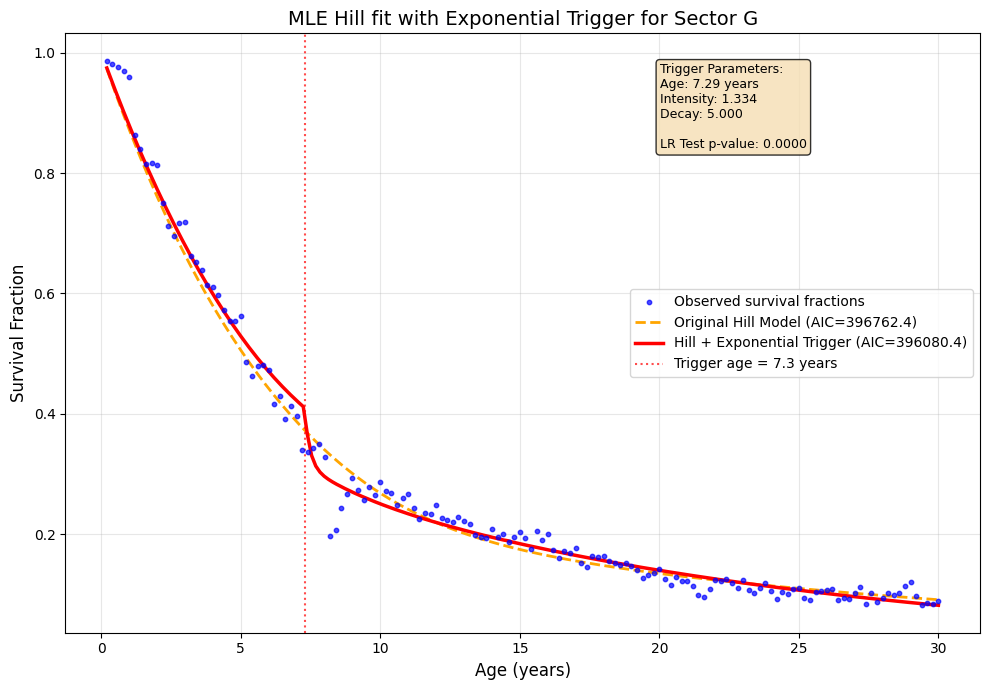


SUMMARY FOR SECTOR G:
Trigger occurs at age 7.29 years
Peak additional mortality: 1.334
Decay rate: 5.000 (half-life = 0.14 years)
Log-likelihood improvement: 344.01
✓ Trigger model is significantly better (p < 0.05)


In [191]:
results_G = compare_hill_vs_trigger('G', ages, df_analysis, df_params)
plot_sector_with_trigger(results_G, 'G', ages, df_analysis, save_plot=False)